In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import time 
import tqdm
import glob
import yaml
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import multiprocessing as mp

from mlguess.pit import pit_deviation_skill_score, pit_deviation
from mlguess.keras.models import EvidentialRegressorDNN


from mlguess.keras.callbacks import get_callbacks
from mlguess.regression_uq import compute_results
#from mlguess.regression_uq import Test1AB

2024-07-10 09:28:47.837011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 09:28:47.837069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 09:28:48.070289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 09:28:48.209254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 09:29:35.853098: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [4]:
"source ~/.bashrc","module unload cuda cudnn","conda activate guess-gpu3",'CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))','export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib','export XLA_FLAGS=--xla_gpu_cuda_data_dir=$CONDA_PREFIX'

('source ~/.bashrc',
 'module unload cuda cudnn',
 'conda activate guess-gpu3',
 'CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))',
 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib',
 'export XLA_FLAGS=--xla_gpu_cuda_data_dir=$CONDA_PREFIX')

In [6]:
config = '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Active_learning/best_50.yml'

In [7]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [8]:
conf['model']

{'activation': 'relu',
 'batch_size': 777,
 'dropout_alpha': 0.152712630043728,
 'epochs': 1000,
 'evidential_coef': 0.654386516729069,
 'hidden_layers': 5,
 'hidden_neurons': 150,
 'kernel_reg': 'l2',
 'l1_weight': 5.13946696844333e-11,
 'l2_weight': 5.1109726042924564e-08,
 'loss': 'evidentialReg',
 'lr': 1.6914868229211361e-06,
 'metrics': 'mae',
 'optimizer': 'adam',
 'use_dropout': True,
 'use_noise': False,
 'verbose': 2}

In [9]:
#met_vars are 11 feature variables, output_vars is my single target variable
met_vars = conf["met_vars"]
output_vars = conf["output_vars"]
seed = conf["seed"]
print(seed)

1000


In [10]:
# this is a list
output_vars

['WG_o(m/s)']

In [11]:
met_vars

['WS_950mb(m/s)',
 'WS_850mb(m/s)',
 'WS_10m(m/s)',
 'PBLH(km)',
 'Ustar(m/s)',
 'Temp_grad(1km_sfc)(C/km)',
 'Temp_grad(2km_sfc)(C/km)',
 'Terrain_height(m)',
 'WindDC(cos)',
 'WindDC(sin)']

In [12]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

In [13]:
train_data_path= '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Data/train_data.csv'

In [14]:
valid_data_path= '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Data/valid_data.csv'

In [15]:
test_data_path= '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Data/test_data.csv'

In [16]:
train_data= pd.read_csv(train_data_path)

In [17]:
valid_data= pd.read_csv(valid_data_path)

In [18]:
test_data= pd.read_csv(test_data_path)

In [19]:
# merging tarina and validation data taht will be used for computing uncertainty
train_valid_data= pd.concat([train_data,valid_data],axis=0,ignore_index=True)

In [20]:
train_valid_data= train_valid_data.drop(['Unnamed: 0','index'], axis=1)

In [21]:
test_data= test_data.drop(['Unnamed: 0','index'], axis=1)

In [22]:
# Set up distributed strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2024-07-10 09:41:12.466195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-07-10 09:41:12.468148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38374 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0
2024-07-10 09:41:12.469784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38374 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-07-10 09:41:12.471374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38374 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [23]:
import random

In [24]:
def seed_everything(seed=1000):
    """Set seeds for reproducibility"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

In [25]:
# Fix seed for reproducibility
seed_everything(seed)

In [26]:
# Take a random 10% sample of the DataFrame
N = 10 # number of iteations to perform
indx_all = np.arange(0,len(train_valid_data))
subset_size = int(len(indx_all)/N)
np.random.shuffle(indx_all) # it will shuffle the indx inplace
initial = train_valid_data.iloc[indx_all[0:subset_size]] # randomly select 5% of the samples
initial = initial.reset_index(drop = True)
rest = train_valid_data.iloc[indx_all[subset_size:]] # rest 95% data
rest = rest.reset_index(drop = True)

# These are for random sampling
initial2 = train_valid_data.iloc[indx_all[0:subset_size]] 
rest2 = train_valid_data.iloc[indx_all[subset_size:]]
initial2 = initial2.reset_index(drop = True)
rest2 = rest2.reset_index(drop = True)

In [27]:
# an array to store the increment in training data
train_size_array = np.arange(0.1, 1.05, 0.1)
# an array to store the value of error metric on the held out test set
RMSE_array = np.zeros((1,N))
RMSE_array2 = np.zeros((1,N))

In [28]:
from tensorflow.keras import backend as K

In [29]:
for i in range(N):
    #initial = initial.sample(frac = 1, random_state=seed).reset_index(drop=True)
    # at i=0, train data here will come from inital 5% data
    x_train = scaler_x.fit_transform(initial[met_vars])
    y_train = scaler_y.fit_transform(initial[output_vars])
    # I will compute unceratinty on the remainder data
    x_rest = scaler_x.transform(rest[met_vars])
    y_rest = scaler_y.transform(rest[output_vars])
    # my held-out test set
    x_test = scaler_x.transform(test_data[met_vars])
    y_test = scaler_y.transform(test_data[output_vars])
    
    #Clear the previous TensorFlow session
    K.clear_session()  # This line ensures a fresh start for each iteration

    # Ensure reproducibility
    seed_everything(seed)

    with strategy.scope():
        # Initialize and build the model from scratch
        model = EvidentialRegressorDNN(**conf["model"])
        model.build_neural_network(x_train.shape[-1], y_train.shape[-1])
        #Train the model
        model.fit(x_train,y_train,
                  validation_split=0.1, #using 10% of the training data as validation split during training
                  callbacks=get_callbacks(conf,path_extend="models"))
    
    # prediction on leftover data
    p_rest = model.predict_uncertainty(x_rest,scaler = scaler_y) # prediction on remaining train_valid data
    mu, aleatoric, epistemic = p_rest
    total = np.sqrt(aleatoric+epistemic)
    
    #prediction on held out test set
    p_test = model.predict_uncertainty(x_test,scaler = scaler_y) # prediction on held out test set
    rmse = mean_squared_error(scaler_y.inverse_transform(y_test),p_test[0])**0.5 
    RMSE_array [0,i] = rmse

    # sorting uncertainty computed on leftover data
    total = pd.DataFrame(total, columns = ['sigma_tot'])
    indx1 = np.arange(0,len(x_rest)) # I will add the indices of the rest data on which prediction was done
    total['indx']= indx1
    total = total.sort_values(by = ['sigma_tot'], ascending = False) # asecnding= False sorts the total uncertainty from higher to lower
    total = total.reset_index(drop = True)
    
    if len(rest)<subset_size:
        indx2 = list(total['indx'])
    else:
        indx2 = list(total['indx'][0:subset_size]) # taking the indices of the top 10% total unc.
    temp_df = rest.iloc[indx2] # now take the samples from the rest data which resulted in top 10 % predicted total uq
    temp_df=temp_df.reset_index(drop=True)
    initial = pd.concat([initial,temp_df],axis=0,ignore_index=True) # add these to the previous training data
    rest = rest.drop(indx2, axis=0)  # drop those sample which I have added to next iteration's train data
    rest = rest.reset_index(drop=True)


    # For random policy
    #initial2 = initial2.sample(frac = 1, random_state=seed).reset_index(drop=True)
    x_train2 = scaler_x.fit_transform(initial2[met_vars])
    y_train2 = scaler_y.fit_transform(initial2[output_vars])
    
    x_test = scaler_x.transform(test_data[met_vars])
    y_test = scaler_y.transform(test_data[output_vars])
    
    #Clear the previous TensorFlow session
    K.clear_session()  # This line ensures a fresh start for each iteration

    
    if i == 0:
        RMSE_array2 [0,i] = rmse
    else:
        with strategy.scope():
            # Initialize and build the model from scratch
            model2 = EvidentialRegressorDNN(**conf["model"])
            model2.build_neural_network(x_train2.shape[-1], y_train2.shape[-1])
        
            model2.fit(x_train2,y_train2,
                      validation_split=0.1, #using 10% of the training data as validation split during training
                      callbacks=get_callbacks(conf,path_extend="models"))

        #prediction on held out test set
        p_test2 = model.predict_uncertainty(x_test,scaler = scaler_y) # prediction on held out test set
        rmse = mean_squared_error(scaler_y.inverse_transform(y_test),p_test2[0])**0.5 
        RMSE_array2 [0,i] = rmse

    indx_r = np.arange(0,len(rest2))
    np.random.shuffle(indx_r)
    if len(rest2)<subset_size:
        indx2 = list(indx_r)
    else:
        indx2 = list(indx_r[0:subset_size])
    temp_df2 = rest2.iloc[indx2]
    temp_df2=temp_df2.reset_index(drop=True)
    initial2 = pd.concat([initial2,temp_df2],axis=0,ignore_index=True)
    rest2 = rest2.drop(indx2, axis=0) 
    rest2 = rest2.reset_index(drop=True)
    print(f"Active Learning Iteration {i+1}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 dense_00 (Dense)            (None, 150)               1650      
                                                                 
 dropout_h_00 (Dropout)      (None, 150)               0         
                                                                 
 dense_01 (Dense)            (None, 150)               22650     
                                                                 
 dropout_h_01 (Dropout)      (None, 150)               0         
                                                                 
 dense_02 (Dense)            (None, 150)               22650     
                                                                 
 dropout_h_02 (Dropout)      (None, 150)               0     

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-07-10 09:41:44.552625: I external/local_xla/xla/service/service.cc:168] XLA service 0x14c8504a9a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-10 09:41:44.552644: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-07-10 09:41:44.552648: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-07-10 09:41:44.552651: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-07-10 09:41:44.552654: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-07-10 09:41:44.564853: I tensorflow/compiler/mlir/tenso

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


21/21 - 15s - loss: 2.9669 - mae: 0.7815 - val_loss: 2.8910 - val_mae: 0.7478 - lr: 1.6915e-06 - 15s/epoch - 706ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 - 0s - loss: 2.9664 - mae: 0.7816 - val_loss: 2.8882 - val_mae: 0.7473 - lr: 1.6915e-06 - 420ms/epoch - 20ms/step
Epoch 3/1000
21/21 - 0s - loss: 2.9661 - mae: 0.7820 - val_loss: 2.8854 - val_mae: 0.7468 - lr: 1.6915e-06 - 426ms/epoch - 20ms/step
Epoch 4/1000
21/21 - 0s - loss: 2.9585 - mae: 0.7799 - val_loss: 2.8825 - val_mae: 0.7463 - lr: 1.6915e-06 - 420ms/epoch - 20ms/step
Epoch 5/1000
21/21 - 0s - loss: 2.9587 - mae: 0.7803 - val_loss: 2.8797 - val_mae: 0.7458 - lr: 1.6915e-06 - 422ms/epoch - 20ms/step
Epoch 6/1000
21/21 - 0s - loss: 2.9534 - mae: 0.7797 - val_loss: 2.8768 - val_mae: 0.7454 - lr: 1.6915e-06 - 423ms/epoch - 20ms/step
Epoch 7/1000
21/21 - 0s - loss: 2.9507 - mae: 0.7789 - val_loss: 2.8739 - val_mae: 0.7449 - lr: 1.6915e-06 - 422ms/epoch - 20ms/step
Epoch 8/1000
21/21 - 0s - loss: 2.9486 - mae: 0.7787 - val_loss: 2.8710 - val_mae: 0.7444 - lr: 1.6915e-06 - 422ms/epoch - 20ms/step
Epoch 9/1000
21/21 - 0s - loss: 2.9434 - mae: 0.7774 - val_loss: 2.8682 - val_mae:

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 7s - loss: 3.0820 - mae: 0.8247 - val_loss: 2.7581 - val_mae: 0.6960 - lr: 1.6915e-06 - 7s/epoch - 161ms/step
Epoch 2/1000
41/41 - 1s - loss: 3.0750 - mae: 0.8234 - val_loss: 2.7556 - val_mae: 0.6959 - lr: 1.6915e-06 - 517ms/epoch - 13ms/step
Epoch 3/1000
41/41 - 1s - loss: 3.0699 - mae: 0.8228 - val_loss: 2.7531 - val_mae: 0.6957 - lr: 1.6915e-06 - 520ms/epoch - 13ms/step
Epoch 4/1000
41/41 - 1s - loss: 3.0619 - mae: 0.8208 - val_loss: 2.7506 - val_mae: 0.6956 - lr: 1.6915e-06 - 518ms/epoch - 13ms/step
Epoch 5/1000
41/41 - 1s - loss: 3.0548 - mae: 0.8194 - val_loss: 2.7481 - val_mae: 0.6955 - lr: 1.6915e-06 - 522ms/epoch - 13ms/step
Epoch 6/1000
41/41 - 1s - loss: 3.0487 - mae: 0.8185 - val_loss: 2.7456 - val_mae: 0.6954 - lr: 1.6915e-06 - 533ms/epoch - 13ms/step
Epoch 7/1000
41/41 - 1s - loss: 3.0419 - mae: 0.8171 - val_loss: 2.7430 - val_mae: 0.6953 - lr: 1.6915e-06 - 529ms/epoch - 13ms/step
Epoch 8/1000
41/41 - 1s - loss: 3.0343 - mae: 0.8157 - val_loss: 2.7405 - val_mae: 0

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


41/41 - 6s - loss: 3.0377 - mae: 0.7824 - val_loss: 3.0133 - val_mae: 0.7772 - lr: 1.6915e-06 - 6s/epoch - 157ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 1s - loss: 3.0319 - mae: 0.7816 - val_loss: 3.0076 - val_mae: 0.7761 - lr: 1.6915e-06 - 539ms/epoch - 13ms/step
Epoch 3/1000
41/41 - 1s - loss: 3.0248 - mae: 0.7802 - val_loss: 3.0019 - val_mae: 0.7751 - lr: 1.6915e-06 - 543ms/epoch - 13ms/step
Epoch 4/1000
41/41 - 1s - loss: 3.0200 - mae: 0.7796 - val_loss: 2.9963 - val_mae: 0.7740 - lr: 1.6915e-06 - 782ms/epoch - 19ms/step
Epoch 5/1000
41/41 - 1s - loss: 3.0145 - mae: 0.7785 - val_loss: 2.9907 - val_mae: 0.7729 - lr: 1.6915e-06 - 537ms/epoch - 13ms/step
Epoch 6/1000
41/41 - 1s - loss: 3.0080 - mae: 0.7772 - val_loss: 2.9851 - val_mae: 0.7719 - lr: 1.6915e-06 - 540ms/epoch - 13ms/step
Epoch 7/1000
41/41 - 1s - loss: 3.0024 - mae: 0.7762 - val_loss: 2.9795 - val_mae: 0.7708 - lr: 1.6915e-06 - 1s/epoch - 26ms/step
Epoch 8/1000
41/41 - 1s - loss: 2.9962 - mae: 0.7752 - val_loss: 2.9738 - val_mae: 0.7697 - lr: 1.6915e-06 - 561ms/epoch - 14ms/step
Epoch 9/1000
41/41 - 1s - loss: 2.9900 - mae: 0.7740 - val_loss: 2.9682 - val_mae: 0.

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


62/62 - 7s - loss: 3.0588 - mae: 0.8150 - val_loss: 2.7502 - val_mae: 0.7013 - lr: 1.6915e-06 - 7s/epoch - 107ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 - 1s - loss: 3.0489 - mae: 0.8134 - val_loss: 2.7431 - val_mae: 0.7001 - lr: 1.6915e-06 - 645ms/epoch - 10ms/step
Epoch 3/1000
62/62 - 1s - loss: 3.0408 - mae: 0.8124 - val_loss: 2.7358 - val_mae: 0.6987 - lr: 1.6915e-06 - 647ms/epoch - 10ms/step
Epoch 4/1000
62/62 - 1s - loss: 3.0322 - mae: 0.8113 - val_loss: 2.7285 - val_mae: 0.6974 - lr: 1.6915e-06 - 643ms/epoch - 10ms/step
Epoch 5/1000
62/62 - 1s - loss: 3.0223 - mae: 0.8097 - val_loss: 2.7209 - val_mae: 0.6959 - lr: 1.6915e-06 - 639ms/epoch - 10ms/step
Epoch 6/1000
62/62 - 1s - loss: 3.0118 - mae: 0.8077 - val_loss: 2.7133 - val_mae: 0.6945 - lr: 1.6915e-06 - 645ms/epoch - 10ms/step
Epoch 7/1000
62/62 - 1s - loss: 3.0055 - mae: 0.8073 - val_loss: 2.7056 - val_mae: 0.6930 - lr: 1.6915e-06 - 655ms/epoch - 11ms/step
Epoch 8/1000
62/62 - 1s - loss: 2.9937 - mae: 0.8054 - val_loss: 2.6976 - val_mae: 0.6914 - lr: 1.6915e-06 - 646ms/epoch - 10ms/step
Epoch 9/1000
62/62 - 1s - loss: 2.9863 - mae: 0.8047 - val_loss: 2.6895 - val_mae:

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


62/62 - 7s - loss: 3.0344 - mae: 0.7816 - val_loss: 3.0739 - val_mae: 0.7992 - lr: 1.6915e-06 - 7s/epoch - 116ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 - 1s - loss: 3.0250 - mae: 0.7799 - val_loss: 3.0650 - val_mae: 0.7975 - lr: 1.6915e-06 - 653ms/epoch - 11ms/step
Epoch 3/1000
62/62 - 1s - loss: 3.0152 - mae: 0.7781 - val_loss: 3.0562 - val_mae: 0.7958 - lr: 1.6915e-06 - 646ms/epoch - 10ms/step
Epoch 4/1000
62/62 - 1s - loss: 3.0067 - mae: 0.7768 - val_loss: 3.0474 - val_mae: 0.7942 - lr: 1.6915e-06 - 654ms/epoch - 11ms/step
Epoch 5/1000
62/62 - 1s - loss: 2.9969 - mae: 0.7749 - val_loss: 3.0386 - val_mae: 0.7926 - lr: 1.6915e-06 - 657ms/epoch - 11ms/step
Epoch 6/1000
62/62 - 1s - loss: 2.9906 - mae: 0.7742 - val_loss: 3.0297 - val_mae: 0.7909 - lr: 1.6915e-06 - 638ms/epoch - 10ms/step
Epoch 7/1000
62/62 - 1s - loss: 2.9793 - mae: 0.7718 - val_loss: 3.0208 - val_mae: 0.7892 - lr: 1.6915e-06 - 643ms/epoch - 10ms/step
Epoch 8/1000
62/62 - 1s - loss: 2.9724 - mae: 0.7709 - val_loss: 3.0117 - val_mae: 0.7875 - lr: 1.6915e-06 - 655ms/epoch - 11ms/step
Epoch 9/1000
62/62 - 1s - loss: 2.9626 - mae: 0.7690 - val_loss: 3.0026 - val_mae:

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


82/82 - 7s - loss: 3.0423 - mae: 0.8095 - val_loss: 2.7101 - val_mae: 0.6867 - lr: 1.6915e-06 - 7s/epoch - 91ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 - 1s - loss: 3.0312 - mae: 0.8080 - val_loss: 2.7020 - val_mae: 0.6853 - lr: 1.6915e-06 - 756ms/epoch - 9ms/step
Epoch 3/1000
82/82 - 1s - loss: 3.0199 - mae: 0.8063 - val_loss: 2.6935 - val_mae: 0.6837 - lr: 1.6915e-06 - 754ms/epoch - 9ms/step
Epoch 4/1000
82/82 - 1s - loss: 3.0097 - mae: 0.8054 - val_loss: 2.6850 - val_mae: 0.6822 - lr: 1.6915e-06 - 789ms/epoch - 10ms/step
Epoch 5/1000
82/82 - 1s - loss: 2.9957 - mae: 0.8029 - val_loss: 2.6760 - val_mae: 0.6806 - lr: 1.6915e-06 - 767ms/epoch - 9ms/step
Epoch 6/1000
82/82 - 1s - loss: 2.9854 - mae: 0.8019 - val_loss: 2.6670 - val_mae: 0.6789 - lr: 1.6915e-06 - 765ms/epoch - 9ms/step
Epoch 7/1000
82/82 - 1s - loss: 2.9734 - mae: 0.8003 - val_loss: 2.6578 - val_mae: 0.6772 - lr: 1.6915e-06 - 762ms/epoch - 9ms/step
Epoch 8/1000
82/82 - 1s - loss: 2.9607 - mae: 0.7985 - val_loss: 2.6484 - val_mae: 0.6754 - lr: 1.6915e-06 - 764ms/epoch - 9ms/step
Epoch 9/1000
82/82 - 1s - loss: 2.9489 - mae: 0.7970 - val_loss: 2.6388 - val_mae: 0.673

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


82/82 - 7s - loss: 3.0349 - mae: 0.7820 - val_loss: 3.0066 - val_mae: 0.7757 - lr: 1.6915e-06 - 7s/epoch - 91ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 - 1s - loss: 3.0224 - mae: 0.7798 - val_loss: 2.9950 - val_mae: 0.7734 - lr: 1.6915e-06 - 793ms/epoch - 10ms/step
Epoch 3/1000
82/82 - 1s - loss: 3.0118 - mae: 0.7781 - val_loss: 2.9834 - val_mae: 0.7712 - lr: 1.6915e-06 - 786ms/epoch - 10ms/step
Epoch 4/1000
82/82 - 1s - loss: 2.9986 - mae: 0.7757 - val_loss: 2.9719 - val_mae: 0.7690 - lr: 1.6915e-06 - 776ms/epoch - 9ms/step
Epoch 5/1000
82/82 - 1s - loss: 2.9875 - mae: 0.7738 - val_loss: 2.9603 - val_mae: 0.7667 - lr: 1.6915e-06 - 776ms/epoch - 9ms/step
Epoch 6/1000
82/82 - 1s - loss: 2.9759 - mae: 0.7717 - val_loss: 2.9484 - val_mae: 0.7645 - lr: 1.6915e-06 - 781ms/epoch - 10ms/step
Epoch 7/1000
82/82 - 1s - loss: 2.9636 - mae: 0.7695 - val_loss: 2.9363 - val_mae: 0.7621 - lr: 1.6915e-06 - 782ms/epoch - 10ms/step
Epoch 8/1000
82/82 - 1s - loss: 2.9512 - mae: 0.7674 - val_loss: 2.9240 - val_mae: 0.7597 - lr: 1.6915e-06 - 792ms/epoch - 10ms/step
Epoch 9/1000
82/82 - 1s - loss: 2.9393 - mae: 0.7652 - val_loss: 2.9115 - val_mae: 0

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


103/103 - 7s - loss: 3.0247 - mae: 0.8028 - val_loss: 2.7387 - val_mae: 0.6987 - lr: 1.6915e-06 - 7s/epoch - 73ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 - 1s - loss: 3.0114 - mae: 0.8013 - val_loss: 2.7262 - val_mae: 0.6961 - lr: 1.6915e-06 - 896ms/epoch - 9ms/step
Epoch 3/1000
103/103 - 1s - loss: 2.9971 - mae: 0.7995 - val_loss: 2.7131 - val_mae: 0.6933 - lr: 1.6915e-06 - 887ms/epoch - 9ms/step
Epoch 4/1000
103/103 - 1s - loss: 2.9832 - mae: 0.7977 - val_loss: 2.6998 - val_mae: 0.6904 - lr: 1.6915e-06 - 887ms/epoch - 9ms/step
Epoch 5/1000
103/103 - 1s - loss: 2.9694 - mae: 0.7960 - val_loss: 2.6862 - val_mae: 0.6875 - lr: 1.6915e-06 - 879ms/epoch - 9ms/step
Epoch 6/1000
103/103 - 1s - loss: 2.9544 - mae: 0.7940 - val_loss: 2.6726 - val_mae: 0.6846 - lr: 1.6915e-06 - 894ms/epoch - 9ms/step
Epoch 7/1000
103/103 - 1s - loss: 2.9382 - mae: 0.7915 - val_loss: 2.6586 - val_mae: 0.6815 - lr: 1.6915e-06 - 890ms/epoch - 9ms/step
Epoch 8/1000
103/103 - 1s - loss: 2.9236 - mae: 0.7901 - val_loss: 2.6434 - val_mae: 0.6780 - lr: 1.6915e-06 - 916ms/epoch - 9ms/step
Epoch 9/1000
103/103 - 1s - loss: 2.9078 - mae: 0.7879 - val_loss: 2.6279 -

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


103/103 - 8s - loss: 3.0319 - mae: 0.7813 - val_loss: 2.9866 - val_mae: 0.7701 - lr: 1.6915e-06 - 8s/epoch - 73ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 - 1s - loss: 3.0190 - mae: 0.7793 - val_loss: 2.9721 - val_mae: 0.7672 - lr: 1.6915e-06 - 881ms/epoch - 9ms/step
Epoch 3/1000
103/103 - 1s - loss: 3.0039 - mae: 0.7767 - val_loss: 2.9578 - val_mae: 0.7645 - lr: 1.6915e-06 - 881ms/epoch - 9ms/step
Epoch 4/1000
103/103 - 1s - loss: 2.9903 - mae: 0.7745 - val_loss: 2.9434 - val_mae: 0.7617 - lr: 1.6915e-06 - 882ms/epoch - 9ms/step
Epoch 5/1000
103/103 - 1s - loss: 2.9741 - mae: 0.7713 - val_loss: 2.9289 - val_mae: 0.7589 - lr: 1.6915e-06 - 877ms/epoch - 9ms/step
Epoch 6/1000
103/103 - 1s - loss: 2.9595 - mae: 0.7691 - val_loss: 2.9140 - val_mae: 0.7560 - lr: 1.6915e-06 - 905ms/epoch - 9ms/step
Epoch 7/1000
103/103 - 1s - loss: 2.9444 - mae: 0.7664 - val_loss: 2.8988 - val_mae: 0.7530 - lr: 1.6915e-06 - 904ms/epoch - 9ms/step
Epoch 8/1000
103/103 - 1s - loss: 2.9288 - mae: 0.7637 - val_loss: 2.8831 - val_mae: 0.7500 - lr: 1.6915e-06 - 895ms/epoch - 9ms/step
Epoch 9/1000
103/103 - 1s - loss: 2.9143 - mae: 0.7614 - val_loss: 2.8668 -

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


123/123 - 7s - loss: 3.0144 - mae: 0.7992 - val_loss: 2.7294 - val_mae: 0.6962 - lr: 1.6915e-06 - 7s/epoch - 57ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


123/123 - 1s - loss: 2.9974 - mae: 0.7970 - val_loss: 2.7145 - val_mae: 0.6929 - lr: 1.6915e-06 - 985ms/epoch - 8ms/step
Epoch 3/1000
123/123 - 1s - loss: 2.9814 - mae: 0.7951 - val_loss: 2.6984 - val_mae: 0.6893 - lr: 1.6915e-06 - 991ms/epoch - 8ms/step
Epoch 4/1000
123/123 - 1s - loss: 2.9640 - mae: 0.7929 - val_loss: 2.6826 - val_mae: 0.6858 - lr: 1.6915e-06 - 990ms/epoch - 8ms/step
Epoch 5/1000
123/123 - 1s - loss: 2.9453 - mae: 0.7903 - val_loss: 2.6657 - val_mae: 0.6818 - lr: 1.6915e-06 - 983ms/epoch - 8ms/step
Epoch 6/1000
123/123 - 1s - loss: 2.9276 - mae: 0.7879 - val_loss: 2.6480 - val_mae: 0.6776 - lr: 1.6915e-06 - 985ms/epoch - 8ms/step
Epoch 7/1000
123/123 - 1s - loss: 2.9082 - mae: 0.7852 - val_loss: 2.6298 - val_mae: 0.6732 - lr: 1.6915e-06 - 978ms/epoch - 8ms/step
Epoch 8/1000
123/123 - 1s - loss: 2.8889 - mae: 0.7823 - val_loss: 2.6112 - val_mae: 0.6686 - lr: 1.6915e-06 - 985ms/epoch - 8ms/step
Epoch 9/1000
123/123 - 1s - loss: 2.8691 - mae: 0.7797 - val_loss: 2.5923 -

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


123/123 - 8s - loss: 3.0293 - mae: 0.7805 - val_loss: 2.9991 - val_mae: 0.7743 - lr: 1.6915e-06 - 8s/epoch - 66ms/step
Epoch 2/1000
123/123 - 1s - loss: 3.0114 - mae: 0.7775 - val_loss: 2.9821 - val_mae: 0.7711 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 3/1000
123/123 - 1s - loss: 2.9941 - mae: 0.7746 - val_loss: 2.9652 - val_mae: 0.7679 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 4/1000
123/123 - 1s - loss: 2.9765 - mae: 0.7714 - val_loss: 2.9480 - val_mae: 0.7647 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 5/1000
123/123 - 1s - loss: 2.9596 - mae: 0.7688 - val_loss: 2.9304 - val_mae: 0.7614 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 6/1000
123/123 - 1s - loss: 2.9409 - mae: 0.7652 - val_loss: 2.9121 - val_mae: 0.7579 - lr: 1.6915e-06 - 1s/epoch - 9ms/step
Epoch 7/1000
123/123 - 1s - loss: 2.9210 - mae: 0.7618 - val_loss: 2.8932 - val_mae: 0.7543 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 8/1000
123/123 - 1s - loss: 2.9039 - mae: 0.7590 - val_loss: 2.8734 - val_mae: 0.7505 - l

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


144/144 - 7s - loss: 3.0135 - mae: 0.7994 - val_loss: 2.6046 - val_mae: 0.6484 - lr: 1.6915e-06 - 7s/epoch - 49ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 - 1s - loss: 2.9923 - mae: 0.7963 - val_loss: 2.5917 - val_mae: 0.6457 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 3/1000
144/144 - 1s - loss: 2.9725 - mae: 0.7938 - val_loss: 2.5784 - val_mae: 0.6428 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 4/1000
144/144 - 1s - loss: 2.9526 - mae: 0.7911 - val_loss: 2.5647 - val_mae: 0.6399 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 5/1000
144/144 - 1s - loss: 2.9310 - mae: 0.7884 - val_loss: 2.5511 - val_mae: 0.6371 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 6/1000
144/144 - 1s - loss: 2.9089 - mae: 0.7852 - val_loss: 2.5371 - val_mae: 0.6342 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 7/1000
144/144 - 1s - loss: 2.8866 - mae: 0.7820 - val_loss: 2.5221 - val_mae: 0.6310 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 8/1000
144/144 - 1s - loss: 2.8634 - mae: 0.7787 - val_loss: 2.5064 - val_mae: 0.6275 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 9/1000
144/144 - 1s - loss: 2.8392 - mae: 0.7747 - val_loss: 2.4901 - val_mae: 0.6238 - lr

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


144/144 - 7s - loss: 3.0282 - mae: 0.7804 - val_loss: 3.0113 - val_mae: 0.7790 - lr: 1.6915e-06 - 7s/epoch - 49ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 - 1s - loss: 3.0071 - mae: 0.7767 - val_loss: 2.9911 - val_mae: 0.7751 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 3/1000
144/144 - 1s - loss: 2.9867 - mae: 0.7732 - val_loss: 2.9708 - val_mae: 0.7713 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 4/1000
144/144 - 1s - loss: 2.9666 - mae: 0.7698 - val_loss: 2.9500 - val_mae: 0.7672 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 5/1000
144/144 - 1s - loss: 2.9462 - mae: 0.7663 - val_loss: 2.9286 - val_mae: 0.7631 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 6/1000
144/144 - 1s - loss: 2.9239 - mae: 0.7623 - val_loss: 2.9062 - val_mae: 0.7587 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 7/1000
144/144 - 1s - loss: 2.9026 - mae: 0.7588 - val_loss: 2.8828 - val_mae: 0.7541 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 8/1000
144/144 - 1s - loss: 2.8780 - mae: 0.7543 - val_loss: 2.8581 - val_mae: 0.7492 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 9/1000
144/144 - 1s - loss: 2.8545 - mae: 0.7501 - val_loss: 2.8321 - val_mae: 0.7438 - lr

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


164/164 - 8s - loss: 2.9928 - mae: 0.7918 - val_loss: 2.6969 - val_mae: 0.6865 - lr: 1.6915e-06 - 8s/epoch - 51ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 - 1s - loss: 2.9709 - mae: 0.7891 - val_loss: 2.6774 - val_mae: 0.6819 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 3/1000
164/164 - 1s - loss: 2.9472 - mae: 0.7861 - val_loss: 2.6572 - val_mae: 0.6771 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 4/1000
164/164 - 1s - loss: 2.9229 - mae: 0.7827 - val_loss: 2.6349 - val_mae: 0.6715 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 5/1000
164/164 - 1s - loss: 2.8985 - mae: 0.7795 - val_loss: 2.6116 - val_mae: 0.6656 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 6/1000
164/164 - 1s - loss: 2.8726 - mae: 0.7756 - val_loss: 2.5874 - val_mae: 0.6593 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 7/1000
164/164 - 1s - loss: 2.8461 - mae: 0.7717 - val_loss: 2.5614 - val_mae: 0.6523 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 8/1000
164/164 - 1s - loss: 2.8190 - mae: 0.7676 - val_loss: 2.5341 - val_mae: 0.6448 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 9/1000
164/164 - 1s - loss: 2.7922 - mae: 0.7635 - val_loss: 2.5059 - val_mae: 0.6369 - lr

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


164/164 - 7s - loss: 3.0255 - mae: 0.7797 - val_loss: 3.0202 - val_mae: 0.7821 - lr: 1.6915e-06 - 7s/epoch - 45ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 - 1s - loss: 3.0015 - mae: 0.7755 - val_loss: 2.9971 - val_mae: 0.7777 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 3/1000
164/164 - 1s - loss: 2.9783 - mae: 0.7714 - val_loss: 2.9737 - val_mae: 0.7733 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 4/1000
164/164 - 1s - loss: 2.9555 - mae: 0.7676 - val_loss: 2.9496 - val_mae: 0.7687 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 5/1000
164/164 - 1s - loss: 2.9306 - mae: 0.7633 - val_loss: 2.9244 - val_mae: 0.7639 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 6/1000
164/164 - 2s - loss: 2.9059 - mae: 0.7589 - val_loss: 2.8978 - val_mae: 0.7587 - lr: 1.6915e-06 - 2s/epoch - 13ms/step
Epoch 7/1000
164/164 - 1s - loss: 2.8789 - mae: 0.7541 - val_loss: 2.8696 - val_mae: 0.7532 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 8/1000
164/164 - 1s - loss: 2.8516 - mae: 0.7492 - val_loss: 2.8398 - val_mae: 0.7472 - lr: 1.6915e-06 - 1s/epoch - 8ms/step
Epoch 9/1000
164/164 - 1s - loss: 2.8215 - mae: 0.7437 - val_loss: 2.8083 - val_mae: 0.7408 - l

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


184/184 - 7s - loss: 2.9925 - mae: 0.7925 - val_loss: 2.5839 - val_mae: 0.6420 - lr: 1.6915e-06 - 7s/epoch - 40ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 - 1s - loss: 2.9661 - mae: 0.7888 - val_loss: 2.5684 - val_mae: 0.6386 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 3/1000
184/184 - 1s - loss: 2.9389 - mae: 0.7852 - val_loss: 2.5515 - val_mae: 0.6349 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 4/1000
184/184 - 1s - loss: 2.9118 - mae: 0.7813 - val_loss: 2.5333 - val_mae: 0.6306 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 5/1000
184/184 - 1s - loss: 2.8830 - mae: 0.7771 - val_loss: 2.5141 - val_mae: 0.6261 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 6/1000
184/184 - 1s - loss: 2.8532 - mae: 0.7725 - val_loss: 2.4942 - val_mae: 0.6213 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 7/1000
184/184 - 1s - loss: 2.8214 - mae: 0.7673 - val_loss: 2.4726 - val_mae: 0.6160 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 8/1000
184/184 - 1s - loss: 2.7901 - mae: 0.7622 - val_loss: 2.4500 - val_mae: 0.6102 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 9/1000
184/184 - 1s - loss: 2.7568 - mae: 0.7561 - val_loss: 2.4263 - val_mae: 0.6041 - lr

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


184/184 - 9s - loss: 3.0257 - mae: 0.7800 - val_loss: 2.9966 - val_mae: 0.7748 - lr: 1.6915e-06 - 9s/epoch - 46ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 - 1s - loss: 2.9991 - mae: 0.7754 - val_loss: 2.9709 - val_mae: 0.7700 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 3/1000
184/184 - 1s - loss: 2.9726 - mae: 0.7707 - val_loss: 2.9447 - val_mae: 0.7651 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 4/1000
184/184 - 1s - loss: 2.9457 - mae: 0.7660 - val_loss: 2.9173 - val_mae: 0.7599 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 5/1000
184/184 - 1s - loss: 2.9187 - mae: 0.7615 - val_loss: 2.8884 - val_mae: 0.7544 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 6/1000
184/184 - 1s - loss: 2.8895 - mae: 0.7562 - val_loss: 2.8576 - val_mae: 0.7484 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 7/1000
184/184 - 1s - loss: 2.8577 - mae: 0.7506 - val_loss: 2.8244 - val_mae: 0.7417 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 8/1000
184/184 - 1s - loss: 2.8251 - mae: 0.7445 - val_loss: 2.7891 - val_mae: 0.7345 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 9/1000
184/184 - 1s - loss: 2.7901 - mae: 0.7379 - val_loss: 2.7516 - val_mae: 0.7266 - lr

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


205/205 - 8s - loss: 2.9745 - mae: 0.7862 - val_loss: 2.6549 - val_mae: 0.6702 - lr: 1.6915e-06 - 8s/epoch - 37ms/step
Epoch 2/1000
205/205 - 1s - loss: 2.9449 - mae: 0.7819 - val_loss: 2.6333 - val_mae: 0.6648 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 3/1000
205/205 - 1s - loss: 2.9154 - mae: 0.7780 - val_loss: 2.6108 - val_mae: 0.6592 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 4/1000
205/205 - 1s - loss: 2.8848 - mae: 0.7740 - val_loss: 2.5871 - val_mae: 0.6532 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 5/1000
205/205 - 1s - loss: 2.8532 - mae: 0.7695 - val_loss: 2.5611 - val_mae: 0.6465 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 6/1000
205/205 - 1s - loss: 2.8199 - mae: 0.7644 - val_loss: 2.5331 - val_mae: 0.6390 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 7/1000
205/205 - 1s - loss: 2.7847 - mae: 0.7585 - val_loss: 2.5029 - val_mae: 0.6307 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 8/1000
205/205 - 1s - loss: 2.7490 - mae: 0.7522 - val_loss: 2.4709 - val_mae: 0.6216 - l

INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


205/205 - 9s - loss: 3.0275 - mae: 0.7808 - val_loss: 2.9733 - val_mae: 0.7675 - lr: 1.6915e-06 - 9s/epoch - 43ms/step
Epoch 2/1000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


205/205 - 1s - loss: 2.9986 - mae: 0.7761 - val_loss: 2.9447 - val_mae: 0.7621 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 3/1000
205/205 - 1s - loss: 2.9685 - mae: 0.7707 - val_loss: 2.9154 - val_mae: 0.7565 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 4/1000
205/205 - 1s - loss: 2.9384 - mae: 0.7656 - val_loss: 2.8843 - val_mae: 0.7505 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 5/1000
205/205 - 1s - loss: 2.9073 - mae: 0.7601 - val_loss: 2.8512 - val_mae: 0.7441 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 6/1000
205/205 - 1s - loss: 2.8732 - mae: 0.7541 - val_loss: 2.8154 - val_mae: 0.7369 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 7/1000
205/205 - 1s - loss: 2.8386 - mae: 0.7479 - val_loss: 2.7773 - val_mae: 0.7291 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 8/1000
205/205 - 1s - loss: 2.7998 - mae: 0.7406 - val_loss: 2.7363 - val_mae: 0.7204 - lr: 1.6915e-06 - 1s/epoch - 7ms/step
Epoch 9/1000
205/205 - 1s - loss: 2.7594 - mae: 0.7327 - val_loss: 2.6932 - val_mae: 0.7110 - lr

In [30]:
RMSE_array

array([[2.31249675, 2.31682234, 2.31449716, 2.31604523, 2.31459704,
        2.31748662, 2.3121098 , 2.31095426, 2.30732841, 2.30739514]])

In [31]:
RMSE_array2

array([[2.31249675, 2.3587916 , 2.34973566, 2.33827435, 2.31978115,
        2.31468137, 2.31124779, 2.31003607, 2.30765009, 2.3073954 ]])

In [32]:
len(initial)

176474

In [33]:
len(rest)

0

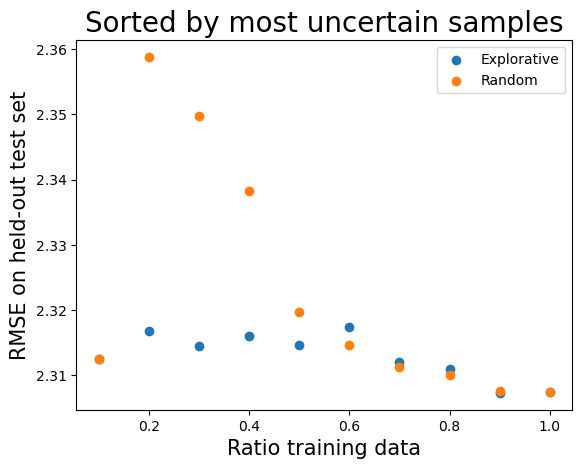

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.scatter(train_size_array,RMSE_array,label='Explorative')
plt.scatter(train_size_array,RMSE_array2, label='Random')
plt.xlabel('Ratio training data',fontsize=15)
plt.ylabel('RMSE on held-out test set',fontsize=15)
plt.legend()
plt.title('Sorted by most uncertain samples',fontsize=20)
plt.savefig('best_50_echo_sorted_by_top_uncertainty.png',dpi=600,bbox_inches='tight')

In [36]:
RMSE_array = pd.DataFrame(RMSE_array)
RMSE_array.to_csv('RMSE_evidential.csv',index=False)

In [37]:
RMSE_array2 = pd.DataFrame(RMSE_array2)
RMSE_array2.to_csv('RMSE_random.csv',index=False)

In [38]:
train_size_array = pd.DataFrame(train_size_array)
train_size_array.to_csv('train_size_array.csv',index=False)

In [40]:
percent_dec = ((RMSE_array - RMSE_array2)/RMSE_array2)*100

In [41]:
percent_dec

,0,1,2,3,4,5,6,7,8,9
0,0.0,-1.77927,-1.499679,-0.950663,-0.223474,0.121194,0.037296,0.039748,-0.01394,-0.000011


In [45]:
percent_dec.shape

(1, 10)

In [47]:
percent_dec=np.array(percent_dec).reshape(10,1)

In [48]:
percent_dec.shape

(10, 1)

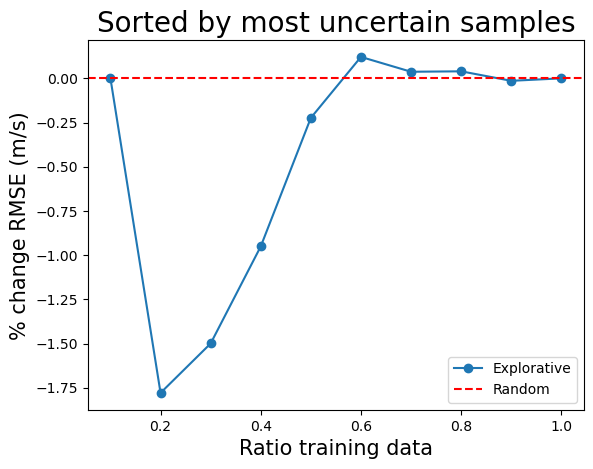

In [51]:
plt.plot(train_size_array,percent_dec,marker='o',label='Explorative')
plt.axhline(y=0, color='r', linestyle='--',label='Random')
plt.xlabel('Ratio training data',fontsize=15)
plt.ylabel('% change RMSE (m/s)',fontsize=15)
plt.legend()
plt.title('Sorted by most uncertain samples',fontsize=20)
plt.savefig('best_50_echo_delta_rmse.png',dpi=600,bbox_inches='tight')